In [19]:
import zipfile
import pandas as pd
import os

with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


In [20]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve 
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold

import seaborn as sns

In [21]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)


(207, 9000)
(620, 9000)


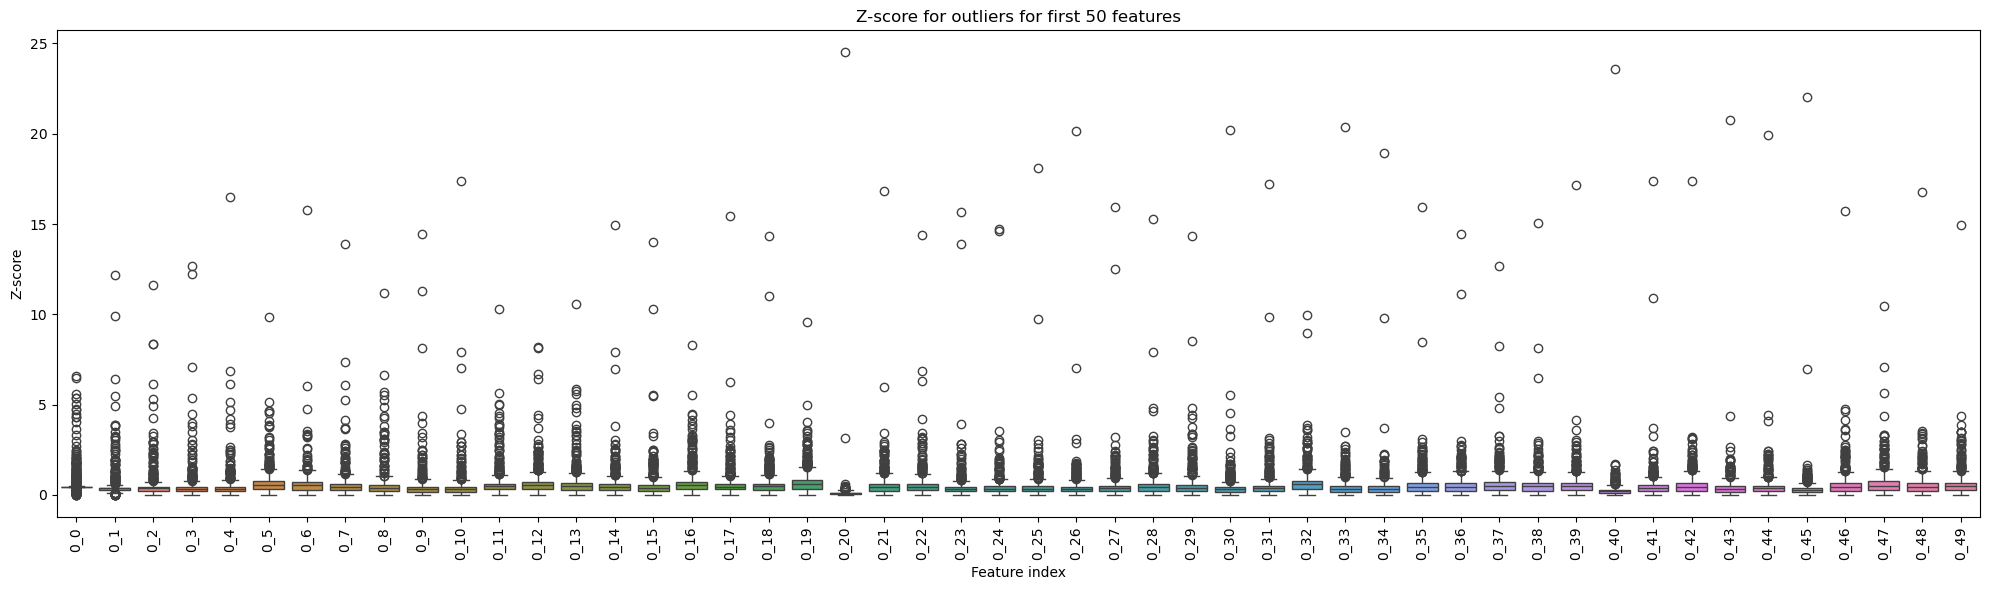

In [22]:
#Preprocessing, scaling: outliers plotten for first 50 features
X_subset = X_train.iloc[:, :50]
z_scores = np.abs(zscore(X_subset))

plt.figure(figsize=(20, 6))
sns.boxplot(data=pd.DataFrame(z_scores, columns=X_subset.columns))
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
#Plot learning curve
# Load functions
def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
    if scoring == 'error':
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5),
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1
        )
        train_scores_mean = 1-np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = 1-np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5),
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 20),
            n_jobs=-1
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({clf_type})")
    plt.xlabel("Number of training objectes")
    plt.ylabel(scoring)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()



In [ ]:
#make the data standardized
#X_train = np.log(X_train)

c:\Users\marti\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [ ]:
#Hyperparameter selection, with feature selection k=200 + learning curve. 
#Feature selection with SelectKBest mutual_info_classif
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())  # standaard: n_neighbors=5
])


NameError: name 'cross_val_score' is not defined

ROC AUC scores per fold: [0.59870766 0.65597148 0.69407308 0.65418895 0.66481738]
Gemiddelde ROC AUC: 0.6535517119469147


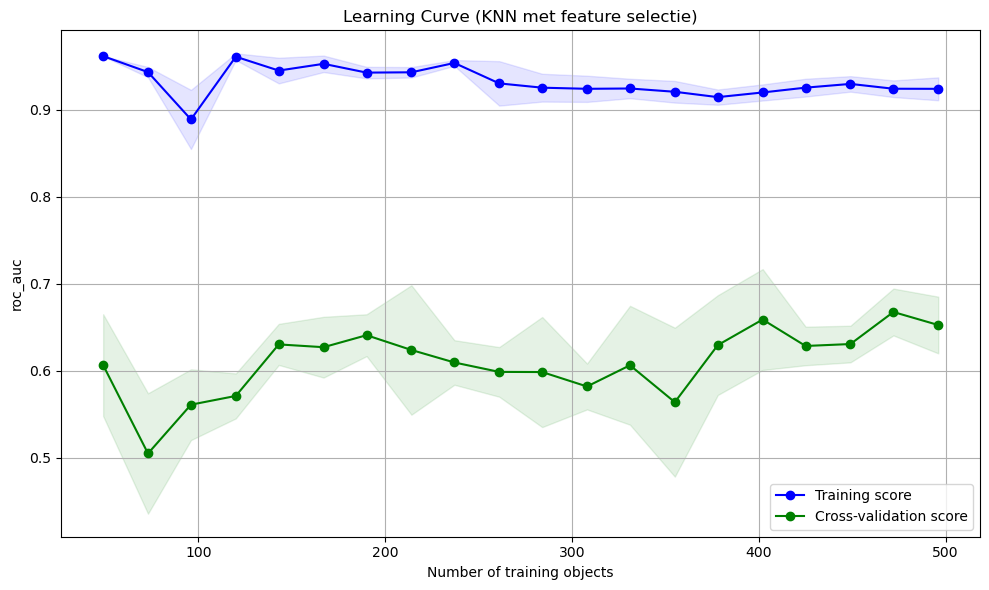

In [37]:
#hyperparameter tuning 
#Hyperparameter selection, with feature selection k=100 + learning curve. 
#Feature selection with SelectKBest mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve, cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Definieer je pipeline (standaard KNN + scaler + feature selectie)
knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])

# 2. Bereken ROC AUC scores via cross-validation (optioneel, maar handig)
scores = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

# 3. Gebruik je eigen functie om de learning curve te plotten
def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
    if scoring == 'error':
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5),
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1
        )
        train_scores_mean = 1 - np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = 1 - np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5),
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 20),
            n_jobs=-1
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({clf_type})")
    plt.xlabel("Number of training objects")
    plt.ylabel(scoring)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# 4. Plotten!
plot_learning_curve(X_train, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN met feature selectie')


Number of features for pre-feature selection: 200
Best estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectKBest(k=100,
                             score_func=<function mutual_info_classif at 0x0000021D71421B20>)),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=15,
                                      weights='distance'))])
Best Score: 0.7962006868060552
best parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 15, 'classifier__metric': 'manhattan'}


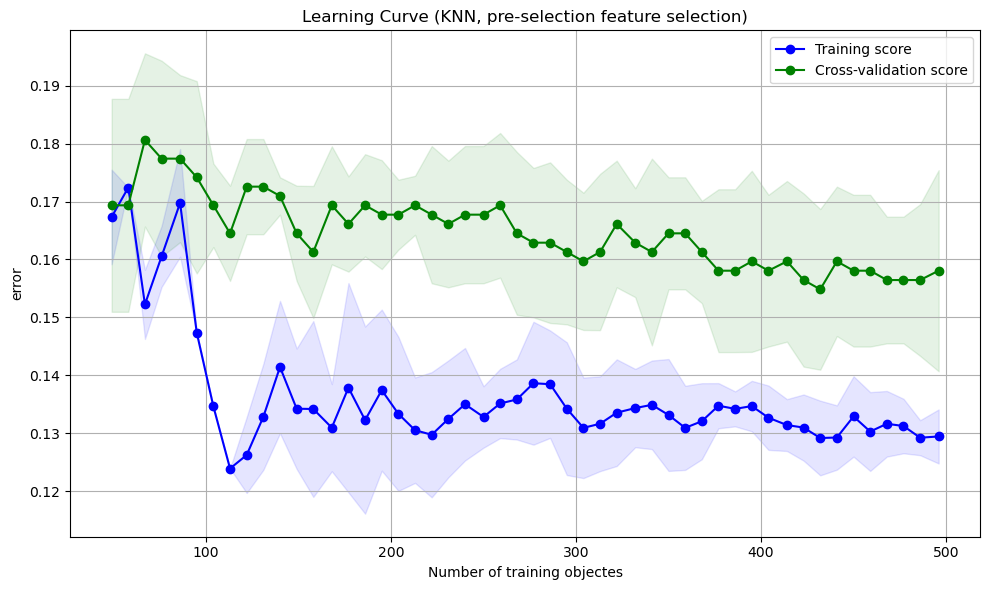

In [ ]:
#Hyperparameter selection, with feature selection k=200 + learning curve. 
#Pre-feature selection with SelectKBest f_classif
selector = SelectKBest(score_func=f_classif, k=200)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

print(f"Number of features for pre-feature selection: {X_train_reduced.shape[1]}")

#Feature selection with SelectKBest mutual_info_classif
knn = Pipeline([('scaler', RobustScaler()),
                ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
                ('classifier', KNeighborsClassifier())])

parameters = {
    'classifier__n_neighbors': [3],
    'classifier__weights': ['uniform'],
    #'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=5,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'  
)

model.fit(X_train_reduced, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("best parameters:", model.best_params_)

plot_learning_curve(X_train_reduced, y_train, classifier=Pipeline, scoring='error', clf_type='KNN, pre-selection feature selection')


Best estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection', SelectKBest(k=100)),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_neighbors=21,
                                      weights='distance'))])
Best Score: 0.8185669413396426
best parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 21, 'classifier__metric': 'chebyshev'}


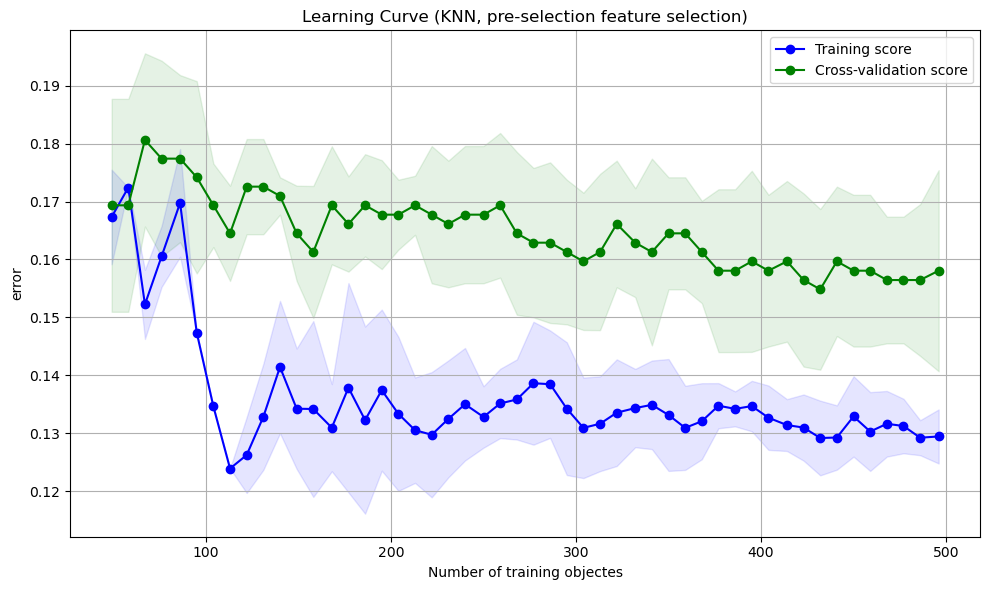

In [39]:
#Hyperparameter selection, with feature selection k=200 + learning curve. 
#Feature selection with SelectKBest f_classif, k=100
knn = Pipeline([('scaler', RobustScaler()),
                ('feature_selection', SelectKBest(f_classif, k=100)),
                ('classifier', KNeighborsClassifier())])

# parameters = {
#     'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
#     'classifier__weights': ['uniform', 'distance'],
#     'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
#     } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=5,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'  
)

model.fit(X_train_reduced, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("best parameters:", model.best_params_)

plot_learning_curve(X_train_reduced, y_train, classifier=pipeline, scoring='error', clf_type='KNN, pre-selection feature selection')